In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import csv

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
standardise = StandardScaler()

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [5]:
tr1 = pd.read_csv('./HeartRate_StressLevel/Train Data/frequency_domain_features_train.csv')
tr2 = pd.read_csv('./HeartRate_StressLevel/Train Data/heart_rate_non_linear_features_train.csv')
tr3 = pd.read_csv('./HeartRate_StressLevel/Train Data/time_domain_features_train.csv')

st1 = pd.read_csv('./HeartRate_StressLevel/Test Data/frequency_domain_features_test.csv')
st2 = pd.read_csv('./HeartRate_StressLevel/Test Data/heart_rate_non_linear_features_test.csv')
st3 = pd.read_csv('./HeartRate_StressLevel/Test Data/time_domain_features_test.csv')

In [ ]:
#tr1.isna().any()

uuid       False    (식별자)  
VLF        False    (Very Low Frequency : 심한 저주파)  
VLF_PCT    False    (Percentage of VLF : 전체 power spectrum에서 VLF가 차지하는 정도)  
LF         False    (Low Frequency : 저주파)  
LF_PCT     False    (Percentage of LF : 전체 power spectrum에서 LF가 차지하는 정도)  
LF_NU      False    (정규화된 단위 (Normalized Unit)로 나타낸 LF 구성 요소)  
HF         False    (High Frequency : 고주파)  
HF_PCT     False    (Percentage of HF : 전체 power spectrum에서 HF가 차지하는 정도)  
HF_NU      False    (정규화된 단위 (Normalized Unit)로 나타낸 HF 구성 요소)  
TP         False    (Total Power : 전체 파워(주파수 스펙트럼의 총량))  
LF_HF      False    (Ratio of LF to HF)  
HF_LF      False    (Ratio of HF to LF)  
dtype: bool

In [ ]:
#tr2.isna().any()

uuid         False  (식별자)  
SD1          False  ( Poincaré plot에서 단기 변동성을 나타내는 지표. 일반적으로 RR 간격(심박사이의 시간 간격)의 단기 변동성을 측정)  
SD2          False  Poincaré plot에서 장기 변동성을 나타내는 지표. 일반적으로 RR 간격의 장기 변동성을 측정  
sampen       False  (Sample Entropy : 시간 시계열 데이터의 복잡성을 측정하기 위한 지표로, 값이 낮을수록 예측 가능성이 높고, 값이 높을수록 복잡성이 큼)  
higuci       False  (Higuchi Fractal Dimension : 시간 시계열 데이터의 프랙탈 차원을 측정하여 데이터의 복잡성을 평가)  
datasetId    False  (Dataset Identifier)  
condition    False  ('no stress', 'interruption', 'time pressure' 등의 조건이나 상황)  
dtype: bool 

In [ ]:
#tr3.isna().any()

MEAN_RR              False  (RR 간격(심박 사이의 시간 간격)의 평균값)  
MEDIAN_RR            False  (RR 간격의 중앙값)  
SDRR                 False  (RR 간격의 표준 편차, 심박 변동성의 측정 지표 중 하나로 사용됨)  
RMSSD                False  (인접한 RR 간격 차이의 제곱 평균의 제곱근, 심박 변동성의 단기 변동성을 측정)  
SDSD                 False  (인접한 RR 간격 차이의 표준 편차, 단기 변동성을 측정)  
SDRR_RMSSD           False  (SDRR과 RMSSD의 비율)  
HR                   False  (HeartRate : 1분당 심박수, bpm)  
pNN25                False  (인접한 RR 간격 차이가 25ms를 초과하는 비율)  
pNN50                False  (인접한 RR 간격 차이가 50ms를 초과하는 비율)  
KURT                 False  (RR 간격의 첨도 (Kurtosis), 데이터 분포의 뾰족함을 측정)  
SKEW                 False  (RR 간격의 왜도 (Skewness), 데이터 분포의 비대칭성을 측정)  
MEAN_REL_RR          False  (상대 RR 간격의 평균값)  
MEDIAN_REL_RR        False  (상대 RR 간격의 중앙값)  
SDRR_REL_RR          False  (상대 RR 간격의 표준 편차)  
RMSSD_REL_RR         False  (상대 RR 간격 차이의 제곱 평균의 제곱근)  
SDSD_REL_RR          False  (상대 RR 간격 차이의 표준 편차)  
SDRR_RMSSD_REL_RR    False  (SDRR_REL_RR과 RMSSD_REL_RR의 비율)  
KURT_REL_RR          False  (상대 RR 간격의 첨도)  
SKEW_REL_RR          False  (상대 RR 간격의 왜도)  
uuid                 False  (식별자)  
dtype: bool

In [6]:
temp1 = pd.merge(tr1, tr2, on='uuid', how='inner')
temp2 = pd.merge(tr3,temp1,on ='uuid', how='inner')
traindf = temp2.drop('uuid',axis=1)
#traindf.info()

label_encode = {"condition": {"no stress":0, "interruption":1, "time pressure":1}}
traindf.replace(label_encode, inplace=True)


In [7]:
temp1 = pd.merge(st1, st2, on='uuid', how='inner')
temp2 = pd.merge(st3,temp1,on ='uuid', how='inner')
testdf = temp2.drop('uuid',axis=1)

testdf.replace(label_encode, inplace=True)


In [8]:
#traindf.info() #col 36
#testdf.info()  #col 35
#for i in traindf.columns :
#    if i not in testdf.columns :
#        print(i)        #HR

traindf = traindf.drop('HR',axis=1)

In [9]:
trainY = traindf.iloc[:,34]
trainX = traindf.iloc[:,:34]
trainX = standardise.fit_transform(trainX)
trainY = pd.DataFrame(trainY)

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=12321)

testY_ans = testdf.iloc[:,34]
testX = testdf.iloc[:,:34]
testX = standardise.fit_transform(testX)
testY = pd.DataFrame(testY_ans)

#SVM

In [30]:
#import sklearn.svm as svm



#ANN

In [10]:
model = Sequential()
model.add(Dense(20,input_dim=34,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

model.fit(trainX,trainY,epochs=20,shuffle=True, verbose=1, validation_data=(valX,valY))

test_loss, test_accuracy = model.evaluate(testX, testY)
predY = model.predict(testX)
mae = mean_absolute_error(testY, predY)
mse = mean_squared_error(testY, predY)
r2 = r2_score(testY, predY)
print(f'MAE : {mae:4f}')
print(f'MSE : {mse:4f}')
print(f'R^2 : {r2:4f}')

m_name = 'ANN_heartrate' + str(round(test_accuracy,3)) + '.h5'
model.save('./saved_models/' + m_name)


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8523 - loss: 0.1128 - val_accuracy: 0.9634 - val_loss: 0.0412
Epoch 2/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9729 - loss: 0.0344 - val_accuracy: 0.9732 - val_loss: 0.0317
Epoch 3/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9838 - loss: 0.0233 - val_accuracy: 0.9869 - val_loss: 0.0164
Epoch 4/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9872 - loss: 0.0153 - val_accuracy: 0.9902 - val_loss: 0.0112
Epoch 5/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9876 - loss: 0.0128 - val_accuracy: 0.9776 - val_loss: 0.0194
Epoch 6/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9893 - loss: 0.0102 - val_accuracy: 0.9874 - val_loss: 0.0118
Epoch 7/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9892 - loss: 0.0097 - val_accuracy: 0.9883 - val_loss: 0.0106
Epoch 8/20
9233/9233 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9903 - loss: 0

MAE : 0.012257
MSE : 0.003181
R^2 : 0.987195


In [11]:
'''m_name = 'ANN_heartrate' + str(round(test_accuracy,3)) + '.h5'
model.save('./saved_models/' + m_name)'''

In [18]:
binY = (predY > 0.5).astype(int)
f1 = f1_score(testY, binY)
print(f'F1 : {f1:4f}')

F1 : 0.995894


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testY, binY)

array([[22081,    77],
       [   78, 18797]], dtype=int64)

In [23]:
from sklearn.metrics import precision_score, recall_score
print('정밀 : ',precision_score(testY, binY),'\n','재현 : ', recall_score(testY, binY))

정밀 :  0.9959203136590018 
 재현 :  0.9958675496688741


<Axes: xlabel='Predicted', ylabel='Actual'>

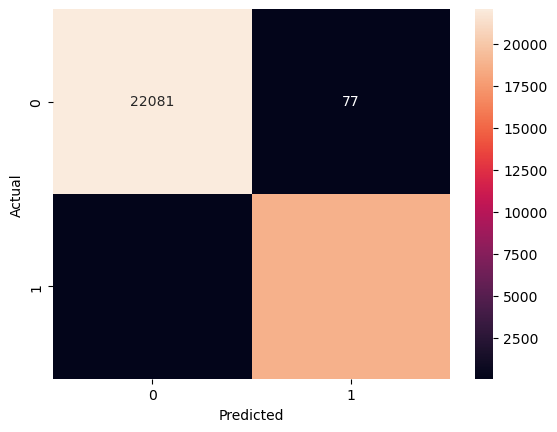

In [24]:
import seaborn as sns
df = pd.DataFrame()

# 데이터 프레임 내에서 새 열 만들기
df['Actual'] = testY
df['Predicted'] = binY

# pd.crosstab을 사용하여 실제 및 예측된 클래스의 빈도 계산
freq = pd.crosstab(df.Actual,df.Predicted)

# sns.heatmap을 사용하여 히트맵 그리기
sns.heatmap(freq,annot=True,fmt="d")